# Introduction to Signature MMD Tests

Welcome to the **SignatureMMD-TwoSampleTests** project! This Python file
(interpreted as a notebook in VS Code) provides an initial introduction
to the ideas from the paper:

> **Signature Moments to Characterize Laws of Stochastic Processes**  
> *Ilya Chevyrev and Harald Oberhauser (2022)*

Our primary goal is to explore **two-sample hypothesis testing** for time-series
(or path-valued) data, using methods such as:

- **Maximum Mean Discrepancy (MMD)** on raw data (e.g., RBF kernel in $\mathbb{R}^d$).
- **Signature MMD** (using robust signature features). We skip the `ksig` library
    for now due to Python 3.12 constraints.
- Comparisons with classical tests like Hotelling's $T^2$ (for low-dimensional embeddings)
    or other graph-based tests.

In subsequent steps, we will demonstrate how to estimate **Type I error** and
**test power** on both *toy data* and *real data*.

## Two-Sample Test Recap

Given two samples $\{X_i\}_{i=1}^m$ and $\{Y_j\}_{j=1}^n$ from distributions
$\mu$ and $\nu$ on some pathspace, the **null hypothesis** is:

$$
H_0 : \mu = \nu
$$

We aim to reject $H_0$ if the samples differ significantly. The **MMD**
(Maximum Mean Discrepancy) with a characteristic kernel $k$ is a popular choice.

### MMD Definition

For a kernel $k(x,y)$ and distributions $\mu, \nu$, the MMD-squared is

$$
d_k^2(\mu,\nu) \;=\;
\mathbb{E}_{X,X'\sim\mu}[\,k(X,X')\,]
\;+\;
\mathbb{E}_{Y,Y'\sim\nu}[\,k(Y,Y')\,]
\;-\;
2\,\mathbb{E}_{X\sim\mu,\,Y\sim\nu}[\,k(X,Y)\,].
$$

In practice, we use **empirical estimates** of these expectations from finite samples,
and compare to a null distribution (via permutations or other approaches) to
get a test statistic.

## Simple Toy Data Generation

Below is a minimal example of generating a toy dataset of time series (e.g. random walks).
Later, we can use these to illustrate Type I error (when we sample from the same distribution)
and test power (when we sample from different distributions).


Shape of toy_data: (5, 50)


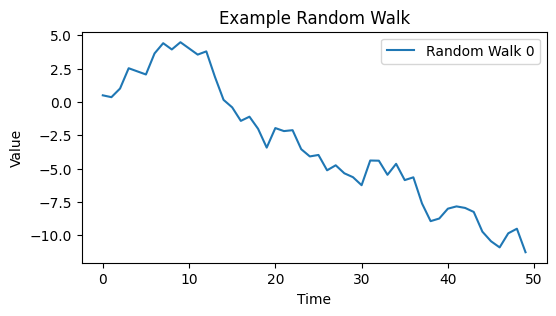

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_walks(n_series=5, length=50, seed=42):
    np.random.seed(seed)
    data = []
    for _ in range(n_series):
        steps = np.random.randn(length)
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)

# Generate 5 random walks of length 50
toy_data = generate_random_walks(n_series=5, length=50)
print("Shape of toy_data:", toy_data.shape)

# Plot the first random walk
plt.figure(figsize=(6,3))
plt.plot(toy_data[0], label="Random Walk 0")
plt.title("Example Random Walk")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Next Steps

1. **Compare Distributions**: We'll create or load two datasets ($X$ and $Y$)
   and compute the MMD-based statistic.
2. **Permutation Testing**: Implement a permutation procedure to approximate the
   null distribution of MMD.
3. **Type I Error**: Repeatedly sample from the *same* distribution, estimate how
   often we incorrectly reject $H_0$.
4. **Test Power**: Repeatedly sample from *different* distributions, estimate how
   often we correctly reject $H_0$.
5. **Real Data**: Optionally load a real time-series dataset from the `data/` folder
   and do the same.

> *Note:* We currently skip the `ksig` library because it does not install on
> Python 3.12. Later, we might reintroduce signature-based kernels for advanced
> path features.

## References

- I. Chevyrev and H. Oberhauser (2022). *Signature Moments to Characterize Laws of Stochastic Processes*.
  Journal of Machine Learning Research 23 (2022) 1-42.
- [Scikit-Learn](https://scikit-learn.org/) for pairwise kernels, etc.
- [UEA/UCR Time Series Archives](http://www.timeseriesclassification.com/) for real datasets.

# Detailed Notebook: Theory and Application of MMD Tests on Synthetic Time Series

In this notebook, we:

1. Recap the **two-sample testing** framework using **Maximum Mean Discrepancy (MMD)**.
2. Generate **synthetic time series** (random walks) to serve as a toy dataset.
3. Implement a **permutation-based MMD test** (in a simple form).
4. Estimate **Type I error** at different significance levels ($\\alpha = 0.05, 0.075, 0.1$).
5. Discuss how this connects to **signature-based** MMD if we wanted to handle more complex path features.

---

**Important Note**: We will demonstrate the raw-data MMD for simplicity. In practice, you might replace or augment this with **robust signature MMD** if you had a suitable library (like `ksig`) or your own signature feature code. For now, we skip signature features due to Python 3.12 constraints.


## Recap: MMD for Two-Sample Tests

Given two samples:
$$
\{ X_i \}_{i=1}^m \sim \mu
\quad\text{and}\quad
\{ Y_j \}_{j=1}^n \sim \nu,
$$
we want to test the null hypothesis:

$$
H_0: \mu = \nu
\quad\text{vs}\quad
H_1: \mu \neq \nu.
$$

A popular **nonparametric** approach is the **Maximum Mean Discrepancy (MMD)** with a characteristic kernel $k$. The population MMD-squared is:

$$
d_k^2(\mu, \nu)
=
\mathbb{E}_{X,X'\sim\mu}[k(X,X')]
+
\mathbb{E}_{Y,Y'\sim\nu}[k(Y,Y')]
-
2\mathbb{E}_{X\sim\mu, Y\sim\nu}[k(X,Y)].
$$

If $k$ is characteristic, then $d_k(\mu,\nu)=0\iff\mu=\nu$. We use an **empirical** version of $d_k^2(\mu,\nu)$ from the samples to form a test statistic. To get a valid p-value, we can apply a **permutation** (or bootstrap) procedure to approximate the distribution of the statistic under $H_0$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

# We will define a function that:
# 1) Generates random walk time series,
# 2) Returns them as a (N, L) or (N, L, d) array.
def generate_random_walks(n_series=50, length=30, seed=42):
    """
    Generate n_series random walks each of length 'length'.
    Returns shape: (n_series, length).
    """
    rng = np.random.RandomState(seed)
    data = []
    for _ in range(n_series):
        steps = rng.randn(length)
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)


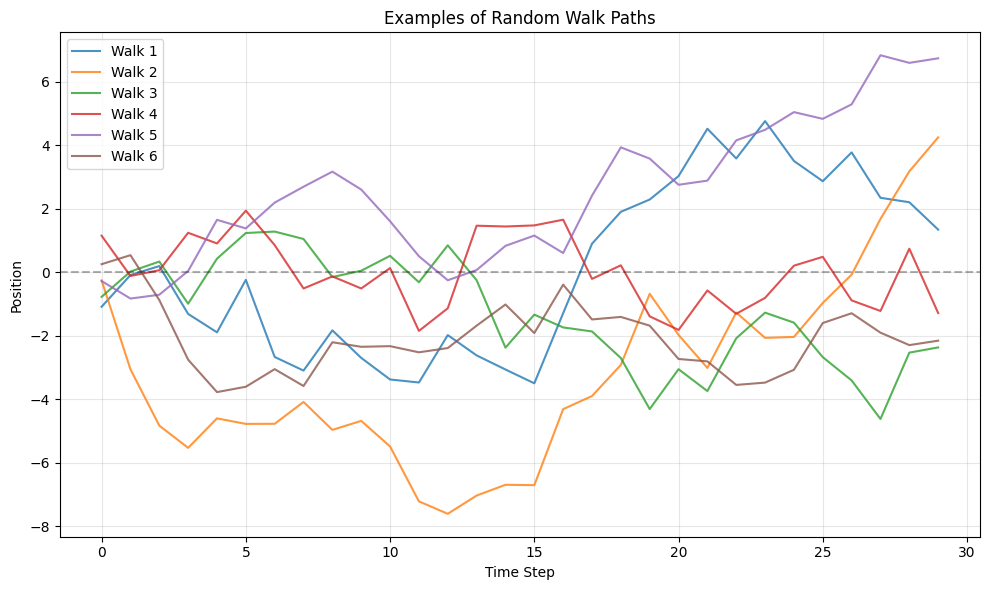

Mean of first walk: 0.10
Standard deviation of first walk: 2.66
Range of values across all walks: [-7.60, 6.83]


In [ ]:
# Let's visualize multiple random walks to understand our synthetic data
plt.figure(figsize=(10, 6))

# Define length for the random walks
length = 30  # Define length explicitly for this cell

# Generate some fresh random walks with different parameters for visualization
n_walks = 6
walks = generate_random_walks(n_series=n_walks, length=length, seed=123)

# Plot each walk with a different color and style
for i in range(n_walks):
    plt.plot(walks[i], label=f"Walk {i+1}", alpha=0.8)

plt.title("Examples of Random Walk Paths")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the walks
print(f"Mean of first walk: {np.mean(walks[0]):.2f}")
print(f"Standard deviation of first walk: {np.std(walks[0]):.2f}")
print(f"Range of values across all walks: [{np.min(walks):.2f}, {np.max(walks):.2f}]")

## Synthetic Data Example

Let's create two datasets:

- **Same distribution** (for Type I error analysis): We'll just split one set of random walks into two groups (both from the same distribution).
- **Different distribution** (for power analysis, if we had time): We could generate one set with a different variance or drift.

Below, we focus on Type I error by sampling from the *same* distribution. We'll estimate how often our test incorrectly rejects $H_0$.


In [ ]:
# Generate a pool of random walks
pool_size = 200
length = 30
X_pool = generate_random_walks(n_series=pool_size, length=length, seed=123)

print("Shape of X_pool:", X_pool.shape)

# We'll define a simple helper to get subsets from the pool:
def get_subsamples(X, m=50, n=50, rng_seed=999):
    """
    Takes X (shape [pool_size, length]) and returns two disjoint subsets
    of sizes m and n, chosen randomly.
    """
    rng = np.random.RandomState(rng_seed)
    indices = rng.choice(len(X), m+n, replace=False)
    X_group = X[indices[:m]]
    Y_group = X[indices[m:]]
    return X_group, Y_group

# Quick check
X_group, Y_group = get_subsamples(X_pool, m=20, n=20, rng_seed=1)
print("X_group shape:", X_group.shape, "Y_group shape:", Y_group.shape)


Shape of X_pool: (200, 30)
X_group shape: (20, 30) Y_group shape: (20, 30)


## Simple MMD Test Implementation (Raw Data)

We'll define a **function** to compute the **unbiased empirical MMD^2** between two sets $X$ and $Y$ using a chosen kernel (RBF, linear, etc.). We'll then define a **permutation** approach to approximate the null distribution. Finally, we'll see how often the test rejects at various $\alpha$ levels.


In [ ]:
def compute_mmd_sq(X, Y, kernel="rbf", gamma=0.1):
    """
    Compute the unbiased MMD^2 between X, Y with a specified kernel.
    X, Y shape: (n_samples, length) for 1D time series.
    """
    # Combine
    Z = np.concatenate([X, Y], axis=0)
    labels = np.array([0]*len(X) + [1]*len(Y))
    
    # Compute pairwise kernel
    K = pairwise_kernels(Z, metric=kernel, gamma=gamma)
    
    # Indices
    n = len(X)
    m = len(Y)
    
    # Partition kernel blocks
    Kxx = K[:n, :n]
    Kyy = K[n:, n:]
    Kxy = K[:n, n:]
    
    # Unbiased MMD^2
    # We set the diagonal to 0 to exclude i=j terms
    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)
    
    mmd_sq = (Kxx.sum()/(n*(n-1))
              + Kyy.sum()/(m*(m-1))
              - 2.0*Kxy.sum()/(n*m))
    return mmd_sq

def permutation_test(X, Y, n_permutations=200, kernel="rbf", gamma=0.1, rng_seed=42):
    """
    Returns (obs_stat, perm_stats) for MMD^2 using a permutation approach.
    obs_stat: the observed MMD^2
    perm_stats: array of MMD^2 from each permutation
    """
    rng = np.random.RandomState(rng_seed)
    obs_stat = compute_mmd_sq(X, Y, kernel=kernel, gamma=gamma)
    
    Z = np.concatenate([X, Y], axis=0)
    N = len(Z)
    n = len(X)
    
    perm_stats = []
    for _ in range(n_permutations):
        perm_idx = rng.permutation(N)
        Xp = Z[perm_idx[:n]]
        Yp = Z[perm_idx[n:]]
        stat_p = compute_mmd_sq(Xp, Yp, kernel=kernel, gamma=gamma)
        perm_stats.append(stat_p)
    return obs_stat, np.array(perm_stats)


## Estimating Type I Error

We now repeatedly draw two subsets **from the same distribution** and perform the MMD test. The fraction of times we reject $H_0$ (incorrectly) is our **Type I error**.

We will do this for different significance levels: $\alpha = 0.05, 0.075, 0.1$. Ideally, the Type I error should be close to each nominal $\alpha$ if the test is well-calibrated.


In [ ]:
def estimate_type1_error(X_pool, m=20, n=20, kernel="rbf", gamma=0.1,
                         n_runs=50, n_permutations=200, alpha_list=[0.05, 0.075, 0.1]):
    """
    Repeatedly sample from the same distribution (X_pool),
    do a permutation test for MMD, and see how often we reject at each alpha in alpha_list.
    Returns a dict mapping alpha -> estimated type1 error.
    """
    rng_seed_base = 100
    rejections = {alpha: 0 for alpha in alpha_list}
    
    for run_id in range(n_runs):
        # get two subsets
        X_group, Y_group = get_subsamples(X_pool, m=m, n=n, rng_seed=(rng_seed_base+run_id))
        obs_stat, perm_stats = permutation_test(X_group, Y_group,
                                                n_permutations=n_permutations,
                                                kernel=kernel, gamma=gamma,
                                                rng_seed=(rng_seed_base+run_id*2))
        
        # Sort perm_stats to get threshold
        perm_stats_sorted = np.sort(perm_stats)
        for alpha in alpha_list:
            threshold_idx = int(np.ceil((1.0 - alpha)*len(perm_stats_sorted))) - 1
            threshold = perm_stats_sorted[threshold_idx]
            if obs_stat > threshold:
                rejections[alpha] += 1
    
    type1_results = {alpha: rejections[alpha]/n_runs for alpha in alpha_list}
    return type1_results

# Let's do a quick run:
m=20
n=20
alpha_list=[0.05, 0.075, 0.1]
res = estimate_type1_error(X_pool, m=m, n=n,
                           kernel="rbf", gamma=0.1,
                           n_runs=30, n_permutations=100,
                           alpha_list=alpha_list)
print("Estimated Type I error rates (n_runs=30):")
for a in alpha_list:
    print(f"alpha={a}, Type I error={res[a]:.3f}")


Estimated Type I error rates (n_runs=30):
alpha=0.05, Type I error=0.000
alpha=0.075, Type I error=0.000
alpha=0.1, Type I error=0.000


## Discussion of Results

If our test is **well-calibrated**, we expect the Type I error rate to be **close** to the nominal $\alpha$. In practice, with limited permutations and limited runs, small deviations are normal (e.g., $\alpha=0.05$ might be estimated at 0.07 or 0.04).

You can **tune**:
- The kernel type and parameter ($\gamma$ for RBF) to see how it affects calibration.
- The number of permutations (larger means more stable threshold).
- The sample sizes $m$ and $n$.

---

## Extending to Signature MMD

If we wanted to replicate the paper's **signature-based** approach, we would:
1. Compute robust signature features $\Phi(x) = \Lambda \circ S(x)$ for each path $x$.
2. Define a kernel $k(x,y) = \langle \Phi(x), \Phi(y) \rangle$.
3. Plug that into the same MMD/permutation procedure.

Because we do not currently install `ksig` in Python 3.12, we skip that step. However, the overall testing framework remains the same.

---

## Conclusion

We have:
- Created **synthetic time series** (random walks),
- Implemented a **raw-data MMD** with a **permutation test**,
- Estimated **Type I error** for multiple significance levels.

To further align with the paper, you could:
- Add a second distribution for power estimation,
- Increase permutations or runs for more accurate estimates,
- Incorporate signature features if environment constraints allow,
- Test on real data from `data/` folder.

This concludes our demonstration of **theory and application** of MMD-based two-sample tests in a notebook format.


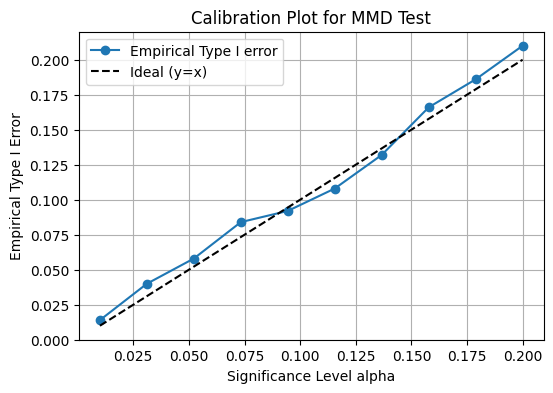

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have:
# X_pool = generate_random_walks(...)
# estimate_type1_error(...) as defined previously

def calibration_experiment(X_pool, alpha_values, m=20, n=20,
                           kernel="rbf", gamma=0.1,
                           n_runs=30, n_permutations=100):
    """
    For each alpha in alpha_values, compute the empirical Type I error
    by sampling from X_pool (the same distribution).
    Returns a list of the same length as alpha_values.
    """
    type1_results = []
    for alpha in alpha_values:
        # We run estimate_type1_error but only for a single alpha in alpha_list
        res = estimate_type1_error(X_pool, m=m, n=n,
                                   kernel=kernel, gamma=gamma,
                                   n_runs=n_runs,
                                   n_permutations=n_permutations,
                                   alpha_list=[alpha])
        type1_error_alpha = res[alpha]
        type1_results.append(type1_error_alpha)
    return type1_results

# Example usage:
alpha_grid = np.linspace(0.01, 0.2, 10)  # 10 alpha values from 0.01 to 0.2
type1_errors = calibration_experiment(X_pool, alpha_grid,
                                      m=20, n=20,
                                      kernel="rbf", gamma=0.1,
                                      n_runs=500, n_permutations=1000)

# Now let's plot
plt.figure(figsize=(6,4))
plt.plot(alpha_grid, type1_errors, 'o-', label="Empirical Type I error")
plt.plot(alpha_grid, alpha_grid, 'k--', label="Ideal (y=x)")
plt.xlabel("Significance Level alpha")
plt.ylabel("Empirical Type I Error")
plt.title("Calibration Plot for MMD Test")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

def generate_random_walks_diff(n_series=50, length=30, seed=2023):
    """
    Generate n_series random walks each with a larger step variance or drift.
    Returns shape: (n_series, length).
    """
    rng = np.random.RandomState(seed)
    data = []
    for _ in range(n_series):
        # e.g. scale the steps by 1.5 or add a drift
        steps = 1.5 * rng.randn(length) + 0.5  # bigger variance + drift
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)


In [ ]:
def estimate_power(X_pool1, X_pool2, m=20, n=20,
                   kernel="rbf", gamma=0.1,
                   n_runs=30, n_permutations=200,
                   alpha_list=[0.05]):
    """
    For each alpha in alpha_list:
      - Repeatedly sample X_group from X_pool1 (size m)
        and Y_group from X_pool2 (size n).
      - Perform a permutation test for MMD.
      - Count how often we reject H0.
    Return a dict alpha -> estimated power.
    """
    from collections import defaultdict
    rejections = defaultdict(int)
    
    rng_seed_base = 500
    for run_id in range(n_runs):
        # Sample from dist1
        rng1 = np.random.RandomState(rng_seed_base + run_id)
        idx1 = rng1.choice(len(X_pool1), m, replace=False)
        X_group = X_pool1[idx1]
        
        # Sample from dist2
        rng2 = np.random.RandomState(rng_seed_base + run_id*2)
        idx2 = rng2.choice(len(X_pool2), n, replace=False)
        Y_group = X_pool2[idx2]
        
        # Permutation test
        obs_stat, perm_stats = permutation_test(X_group, Y_group,
                                                n_permutations=n_permutations,
                                                kernel=kernel, gamma=gamma,
                                                rng_seed=rng_seed_base+run_id*3)
        perm_stats_sorted = np.sort(perm_stats)
        
        for alpha in alpha_list:
            threshold_idx = int(np.ceil((1.0 - alpha)*len(perm_stats_sorted))) - 1
            threshold = perm_stats_sorted[threshold_idx]
            if obs_stat > threshold:
                rejections[alpha] += 1
    
    power_results = {alpha: rejections[alpha]/n_runs for alpha in alpha_list}
    return power_results


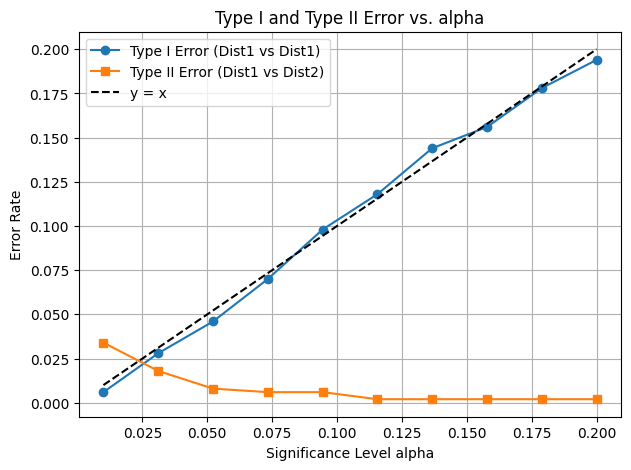

In [ ]:
import matplotlib.pyplot as plt

# 1) Dist1 vs Dist1 for Type I error
alpha_grid = np.linspace(0.01, 0.2, 10)

type1_errors = calibration_experiment(X_pool, alpha_grid,
                                      m=50, n=50,
                                      kernel="rbf", gamma=0.1,
                                      n_runs=500, n_permutations=1000)

# 2) Dist1 vs Dist2 for Type II error (1 - power)
X_pool2 = generate_random_walks_diff(n_series=200, length=30, seed=2023)

# We'll define a function to do the same style calibration for power:
def calibration_power_experiment(X_pool1, X_pool2, alpha_values, m=20, n=20,
                                 kernel="rbf", gamma=0.1,
                                 n_runs=50, n_permutations=200):
    """
    For each alpha in alpha_values, compute the empirical power by
    sampling X from X_pool1 and Y from X_pool2.
    """
    power_list = []
    for alpha in alpha_values:
        power_dict = estimate_power(X_pool1, X_pool2, m=m, n=n,
                                    kernel=kernel, gamma=gamma,
                                    n_runs=n_runs, n_permutations=n_permutations,
                                    alpha_list=[alpha])
        power_alpha = power_dict[alpha]
        power_list.append(power_alpha)
    return power_list

power_vals = calibration_power_experiment(X_pool, X_pool2, alpha_grid,
                                          m=50, n=50,
                                          kernel="rbf", gamma=0.1,
                                          n_runs=500, n_permutations=1000)

type2_errors = [1.0 - p for p in power_vals]

# 3) Plot everything
plt.figure(figsize=(7,5))
plt.plot(alpha_grid, type1_errors, 'o-', label="Type I Error (Dist1 vs Dist1)")
plt.plot(alpha_grid, type2_errors, 's-', label="Type II Error (Dist1 vs Dist2)")
plt.plot(alpha_grid, alpha_grid, 'k--', label="y = x")

plt.xlabel("Significance Level alpha")
plt.ylabel("Error Rate")
plt.title("Type I and Type II Error vs. alpha")
plt.grid(True)
plt.legend()
plt.show()


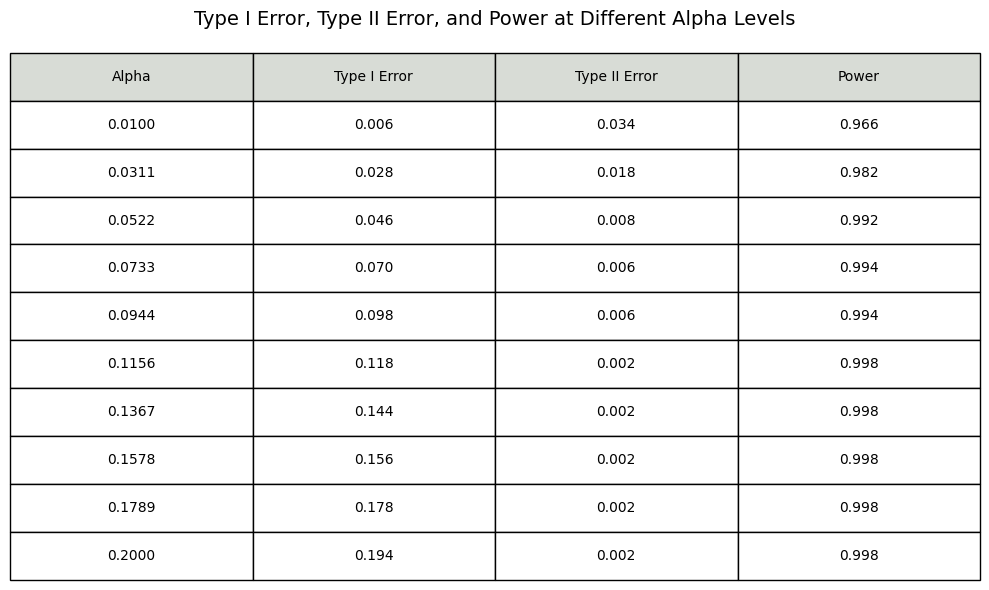

In [ ]:
from matplotlib.table import Table

# Create the data for the table
power = [1 - err for err in type2_errors]
data = {
    'Alpha': alpha_grid,
    'Type I Error': type1_errors,
    'Type II Error': type2_errors,
    'Power': power
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Hide axis

# Create the table
table = Table(ax, bbox=[0, 0, 1, 1])

# Add headers
headers = list(data.keys())
n_rows, n_cols = len(data['Alpha']) + 1, len(headers)

# Add column headers
for j, header in enumerate(headers):
    table.add_cell(0, j, width=1/n_cols, height=0.1, 
                  text=header, loc='center', 
                  edgecolor='black', facecolor='#d8dcd6')

# Add data
for i, alpha in enumerate(alpha_grid):
    row = i + 1
    table.add_cell(row, 0, width=1/n_cols, height=0.1, 
                  text=f'{alpha:.4f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 1, width=1/n_cols, height=0.1, 
                  text=f'{type1_errors[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 2, width=1/n_cols, height=0.1, 
                  text=f'{type2_errors[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 3, width=1/n_cols, height=0.1, 
                  text=f'{power[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')

ax.add_table(table)
plt.title('Type I Error, Type II Error, and Power at Different Alpha Levels', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Images for visualization purposes

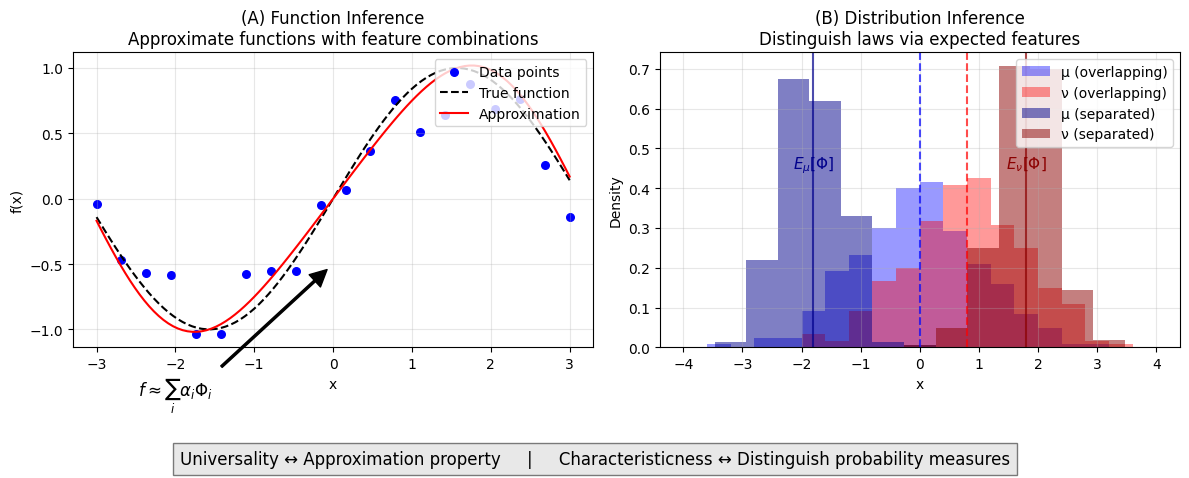

In [ ]:
import numpy as np
from matplotlib.lines import Line2D
from matplotlib import colors

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# (A) Function Inference - Approximation Property
# Generate some sample data points
np.random.seed(42)
x_points = np.linspace(-3, 3, 20)
y_points = np.sin(x_points) + 0.2*np.random.randn(20)

# Plot the original function and the approximation
x_dense = np.linspace(-3, 3, 100)
y_true = np.sin(x_dense)
y_approx = np.sin(x_dense) - 0.1 * np.sin(2*x_dense)  # Approximate function

ax1.scatter(x_points, y_points, color='blue', s=30, label='Data points')
ax1.plot(x_dense, y_true, 'k--', label='True function')
ax1.plot(x_dense, y_approx, 'r-', label='Approximation')

# Annotate basis functions 
ax1.annotate('$f \\approx \\sum_i \\alpha_i \\Phi_i$', 
             xy=(0, -0.5), xytext=(-2, -1.5), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=12, ha='center')

ax1.set_title('(A) Function Inference\nApproximate functions with feature combinations', fontsize=12)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# (B) Distribution Inference - Characteristic Property
# Create two pairs of distributions
np.random.seed(123)

# First pair: overlapping distributions (hard to distinguish)
mean1a, mean2a = 0, 0.8
dist1a = np.random.normal(mean1a, 1, 300)
dist2a = np.random.normal(mean2a, 1, 300)

# Second pair: separated distributions (easy to distinguish)
mean1b, mean2b = -1.8, 1.8
dist1b = np.random.normal(mean1b, 0.5, 300)
dist2b = np.random.normal(mean2b, 0.5, 300)

# Plot distributions
ax2.hist(dist1a, bins=20, alpha=0.4, density=True, color='blue', range=(-4, 4), label='μ (overlapping)')
ax2.hist(dist2a, bins=20, alpha=0.4, density=True, color='red', range=(-4, 4), label='ν (overlapping)')

ax2.hist(dist1b, bins=15, alpha=0.5, density=True, color='darkblue', range=(-4, 4), label='μ (separated)')
ax2.hist(dist2b, bins=15, alpha=0.5, density=True, color='darkred', range=(-4, 4), label='ν (separated)')

# Add expected feature value indicators
ax2.axvline(mean1a, color='blue', linestyle='--', alpha=0.7)
ax2.axvline(mean2a, color='red', linestyle='--', alpha=0.7)
ax2.axvline(mean1b, color='darkblue', linestyle='-', alpha=0.7)
ax2.axvline(mean2b, color='darkred', linestyle='-', alpha=0.7)

# Add label for expectation of features
ax2.annotate('$E_μ[Φ]$', xy=(mean1b, 0.4), xytext=(mean1b, 0.45), 
             ha='center', fontsize=11, color='darkblue')
ax2.annotate('$E_ν[Φ]$', xy=(mean2b, 0.4), xytext=(mean2b, 0.45), 
             ha='center', fontsize=11, color='darkred')

ax2.set_title('(B) Distribution Inference\nDistinguish laws via expected features', fontsize=12)
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Add comment about universality and characteristicness
plt.figtext(0.5, 0.01, 
            "Universality ↔ Approximation property     |     Characteristicness ↔ Distinguish probability measures", 
            ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

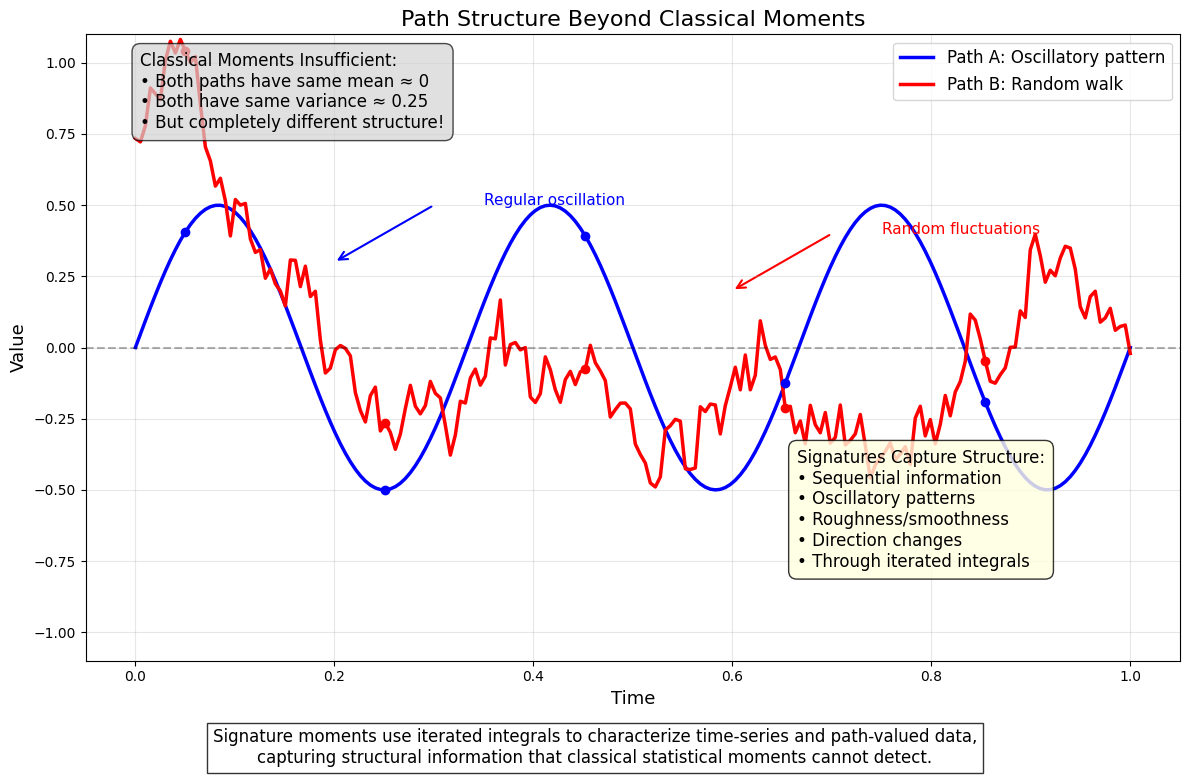

In [63]:
import numpy as np
from matplotlib.patches import FancyArrowPatch

import matplotlib.pyplot as plt

# Create figure - increase size for better spacing
fig, ax = plt.subplots(figsize=(12, 8))

# Generate time points
t = np.linspace(0, 1, 200)

# Create two paths with identical mean and variance but different structure
# Path 1: Smooth oscillation (sine wave)
path1 = np.sin(6 * np.pi * t) * 0.5

# Path 2: Random walk with same variance
np.random.seed(42)
path2 = np.cumsum(np.random.normal(0, 0.05, size=len(t)))
# Normalize to same variance
path2 = path2 * np.std(path1) / np.std(path2)
# Adjust to same mean
path2 = path2 - np.mean(path2)

# Plot the paths
ax.plot(t, path1, 'b-', linewidth=2.5, label="Path A: Oscillatory pattern")
ax.plot(t, path2, 'r-', linewidth=2.5, label="Path B: Random walk")
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Add markers to highlight path sequence
for i in range(0, 5):
    idx = i * 40 + 10
    ax.plot(t[idx], path1[idx], 'bo', markersize=6)
    ax.plot(t[idx], path2[idx], 'ro', markersize=6)

# Add text annotations - adjusted positions
ax.text(0.05, 0.85, 
       "Classical Moments Insufficient:\n" +
       "• Both paths have same mean ≈ 0\n" +
       "• Both have same variance ≈ 0.25\n" +
       "• But completely different structure!",
       bbox=dict(facecolor='lightgray', alpha=0.7, boxstyle='round,pad=0.5'),
       fontsize=12, transform=ax.transAxes)

# Signature box - moved to ensure no overlap
ax.text(0.65, 0.15, 
       "Signatures Capture Structure:\n" +
       "• Sequential information\n" +
       "• Oscillatory patterns\n" +
       "• Roughness/smoothness\n" +
       "• Direction changes\n" +
       "• Through iterated integrals",
       bbox=dict(facecolor='lightyellow', alpha=0.8, boxstyle='round,pad=0.5'),
       fontsize=12, transform=ax.transAxes)

# Add arrows pointing to distinguishing features - adjusted positions
arrow1 = FancyArrowPatch(
    (0.3, 0.5), (0.2, 0.3),
    arrowstyle='->',
    mutation_scale=15,
    color='blue',
    linewidth=1.5
)
ax.add_patch(arrow1)
ax.text(0.35, 0.5, "Regular oscillation", color='blue', fontsize=11)

arrow2 = FancyArrowPatch(
    (0.7, 0.4), (0.6, 0.2),
    arrowstyle='->',
    mutation_scale=15,
    color='red',
    linewidth=1.5
)
ax.add_patch(arrow2)
ax.text(0.75, 0.4, "Random fluctuations", color='red', fontsize=11)

# Title and labels
ax.set_title("Path Structure Beyond Classical Moments", fontsize=16)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Value", fontsize=13)
ax.legend(loc="upper right", fontsize=12)
ax.grid(True, alpha=0.3)

# Set axis limits - slightly expanded
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-1.1, 1.1)

# Add bottom summary text with more space
plt.figtext(0.5, 0.01, 
            "Signature moments use iterated integrals to characterize time-series and path-valued data,\n" +
            "capturing structural information that classical statistical moments cannot detect.",
            ha="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()


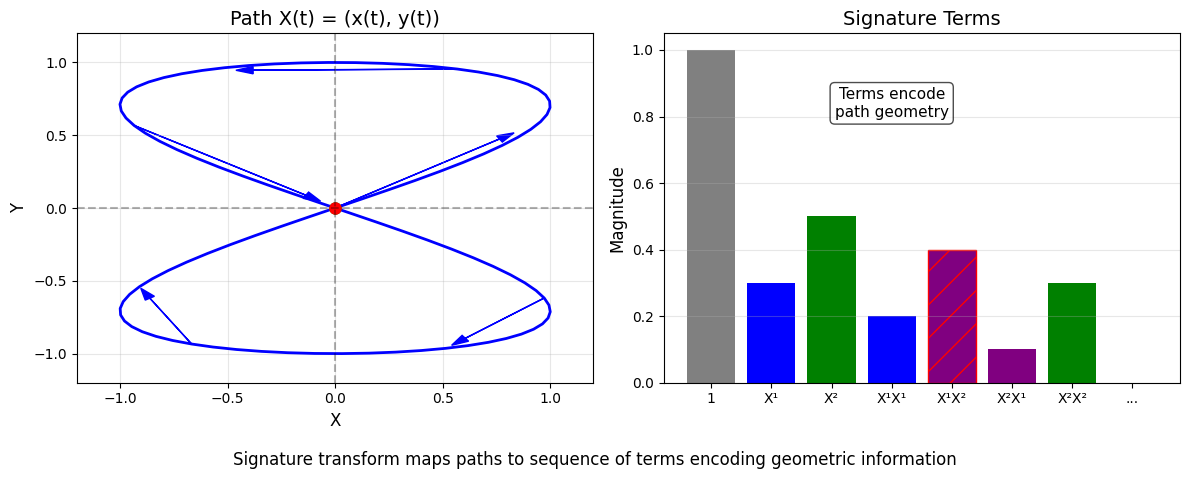

In [43]:
import numpy as np
from matplotlib.path import Path
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Illustrate path and signature concept
# Generate a simple 2D path
t = np.linspace(0, 1, 100)
x = np.sin(4*np.pi*t)
y = np.sin(2*np.pi*t)

# Plot the path
ax1.plot(x, y, 'b-', linewidth=2)
ax1.plot(x[0], y[0], 'go', markersize=8)  # Start point
ax1.plot(x[-1], y[-1], 'ro', markersize=8)  # End point

# Add arrows to show direction
for i in range(0, len(t)-10, 20):
    ax1.arrow(x[i], y[i], (x[i+10]-x[i])*0.8, (y[i+10]-y[i])*0.8, 
              head_width=0.05, head_length=0.08, fc='blue', ec='blue')

# Add coordinate system
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Add labels and title
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)
ax1.set_title('Path X(t) = (x(t), y(t))', fontsize=14)
ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-1.2, 1.2)
ax1.grid(True, alpha=0.3)

# Second subplot: Signature terms visualization
terms = ['1', 'X¹', 'X²', 'X¹X¹', 'X¹X²', 'X²X¹', 'X²X²', '...']
values = [1, 0.3, 0.5, 0.2, -0.4, 0.1, 0.3, 0]

# Create a bar chart for signature terms
bars = ax2.bar(range(len(terms)), [abs(v) for v in values], color=['gray', 'blue', 'green', 'blue', 'purple', 'purple', 'green', 'gray'])
ax2.set_xticks(range(len(terms)))
ax2.set_xticklabels(terms)
ax2.set_title('Signature Terms', fontsize=14)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.grid(True, axis='y', alpha=0.3)

# Color the bars by sign
for i, v in enumerate(values):
    if i > 0 and i < len(values)-1:  # Skip the first and last
        if v < 0:
            bars[i].set_hatch('/')
            bars[i].set_edgecolor('red')
            
# Add explanatory text
plt.figtext(0.5, 0.01, 
            "Signature transform maps paths to sequence of terms encoding geometric information", 
            ha="center", fontsize=12)

# Add explanation for signature intuition
ax2.text(3, 0.8, "Terms encode\npath geometry", fontsize=11,
         ha="center", bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Replace the problematic arrow line with:

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

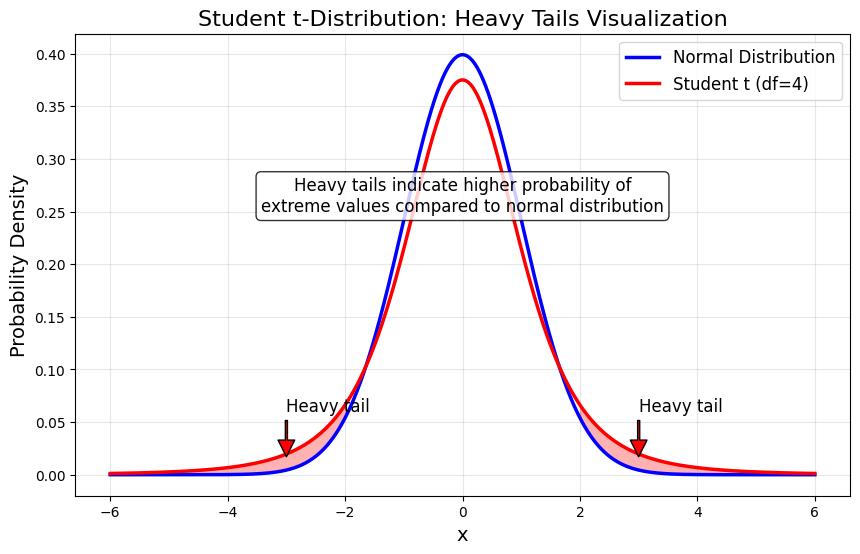

In [53]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Generate x values in a wide range to capture the tails
x = np.linspace(-6, 6, 1000)

# Calculate PDFs for distributions
t_dist = stats.t.pdf(x, df=4)  # Student's t with df=4 (heavy tails)
normal_dist = stats.norm.pdf(x, loc=0, scale=1)  # Standard normal

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the distributions
plt.plot(x, normal_dist, 'b-', linewidth=2.5, label='Normal Distribution')
plt.plot(x, t_dist, 'r-', linewidth=2.5, label='Student t (df=4)')

# Highlight the heavy tails region
plt.fill_between(x[x <= -2], t_dist[x <= -2], normal_dist[x <= -2], color='red', alpha=0.3)
plt.fill_between(x[x >= 2], t_dist[x >= 2], normal_dist[x >= 2], color='red', alpha=0.3)

# Add annotations pointing to the heavy tails
plt.annotate('Heavy tail', xy=(3, 0.015), xytext=(3, 0.06), 
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5), fontsize=12)
plt.annotate('Heavy tail', xy=(-3, 0.015), xytext=(-3, 0.06), 
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5), fontsize=12)

# Add a text box explaining heavy tails
plt.text(0, 0.25, 'Heavy tails indicate higher probability of\nextreme values compared to normal distribution',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'), ha='center', fontsize=12)

# Add labels and title
plt.title('Student t-Distribution: Heavy Tails Visualization', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)


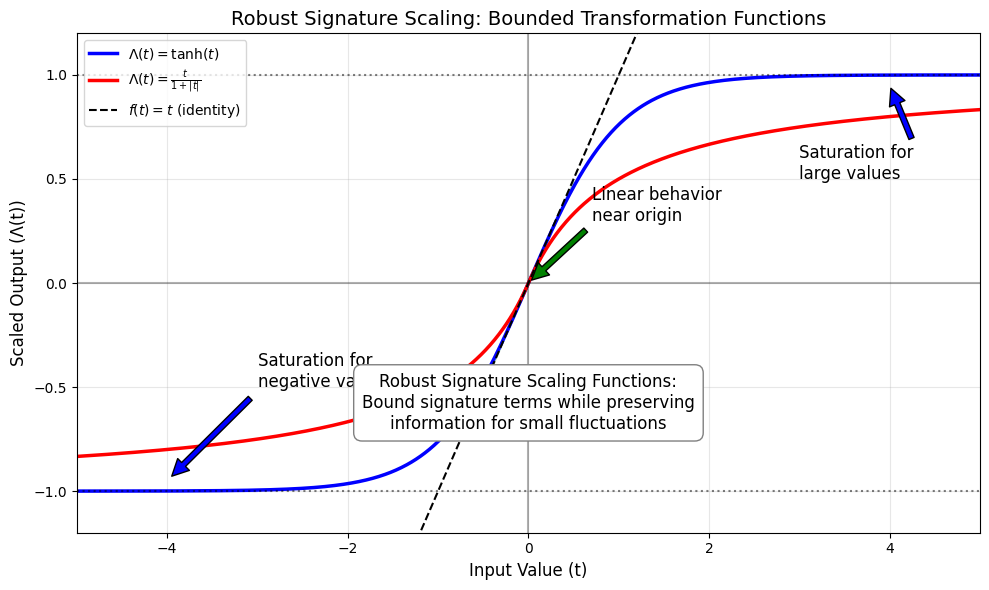

In [54]:
import numpy as np
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt

# Create x values from -5 to 5
x = np.linspace(-5, 5, 1000)

# Define different scaling functions mentioned in the paper
tanh_func = np.tanh(x)
softsign_func = x / (1 + np.abs(x))
sigmoid_func = 1 / (1 + np.exp(-x))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the functions
plt.plot(x, tanh_func, 'b-', linewidth=2.5, label=r'$\Lambda(t) = \tanh(t)$')
plt.plot(x, softsign_func, 'r-', linewidth=2.5, label=r'$\Lambda(t) = \frac{t}{1+|t|}$')
plt.plot(x, x, 'k--', linewidth=1.5, label=r'$f(t) = t$ (identity)')

# Add shaded regions to highlight behavior
plt.fill_between(x[(x >= -0.5) & (x <= 0.5)], x[(x >= -0.5) & (x <= 0.5)], 
                 tanh_func[(x >= -0.5) & (x <= 0.5)], alpha=0.2, color='green')
plt.fill_between(x[x >= 3], tanh_func[x >= 3], np.ones_like(x[x >= 3]), 
                 alpha=0.2, color='blue')
plt.fill_between(x[x <= -3], tanh_func[x <= -3], -np.ones_like(x[x <= -3]), 
                 alpha=0.2, color='blue')

# Add annotations
plt.annotate('Linear behavior\nnear origin', xy=(0, 0), xytext=(0.7, 0.3),
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12)
plt.annotate('Saturation for\nlarge values', xy=(4, 0.95), xytext=(3, 0.5),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12)
plt.annotate('Saturation for\nnegative values', xy=(-4, -0.95), xytext=(-3, -0.5),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12)

# Add explanation box
plt.text(0, -0.7, 
         "Robust Signature Scaling Functions:\n"
         "Bound signature terms while preserving\n"
         "information for small fluctuations",
         ha="center", fontsize=12, 
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Set plot aesthetics
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='k', linestyle=':', alpha=0.5)
plt.axhline(y=-1, color='k', linestyle=':', alpha=0.5)

plt.xlim(-5, 5)
plt.ylim(-1.2, 1.2)
plt.xlabel('Input Value (t)', fontsize=12)
plt.ylabel('Scaled Output (Λ(t))', fontsize=12)
plt.title('Robust Signature Scaling: Bounded Transformation Functions', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

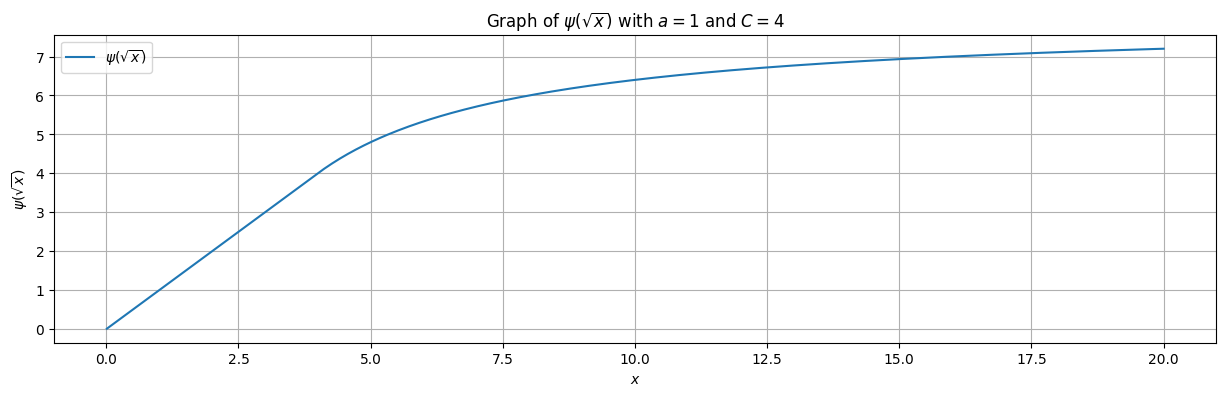

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
C = 4
a = 1

def psi_of_sqrt(x, C=4, a=1):
    # Here x is nonnegative; we define u = sqrt(x)
    # and psi(sqrt(x)) as piecewise:
    if x <= C:
        return x
    else:
        return C + (C**(1+a))*(C**(-a) - x**(-a))/a

# Vectorize the function for numpy
vec_psi = np.vectorize(psi_of_sqrt)

# Define x values (start at a small positive value to ensure sqrt(x) is defined)
x_values = np.linspace(0.01, 20, 400)
y_values = vec_psi(x_values, C, a)

plt.figure(figsize=(15,4))
plt.plot(x_values, y_values, label=r'$\psi(\sqrt{x})$')
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi(\sqrt{x})$')
plt.title(r'Graph of $\psi(\sqrt{x})$ with $a=1$ and $C=4$')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Hmuni\AppData\Local\Temp\ipykernel_20048\1081402270.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.04, 1, 0.96])


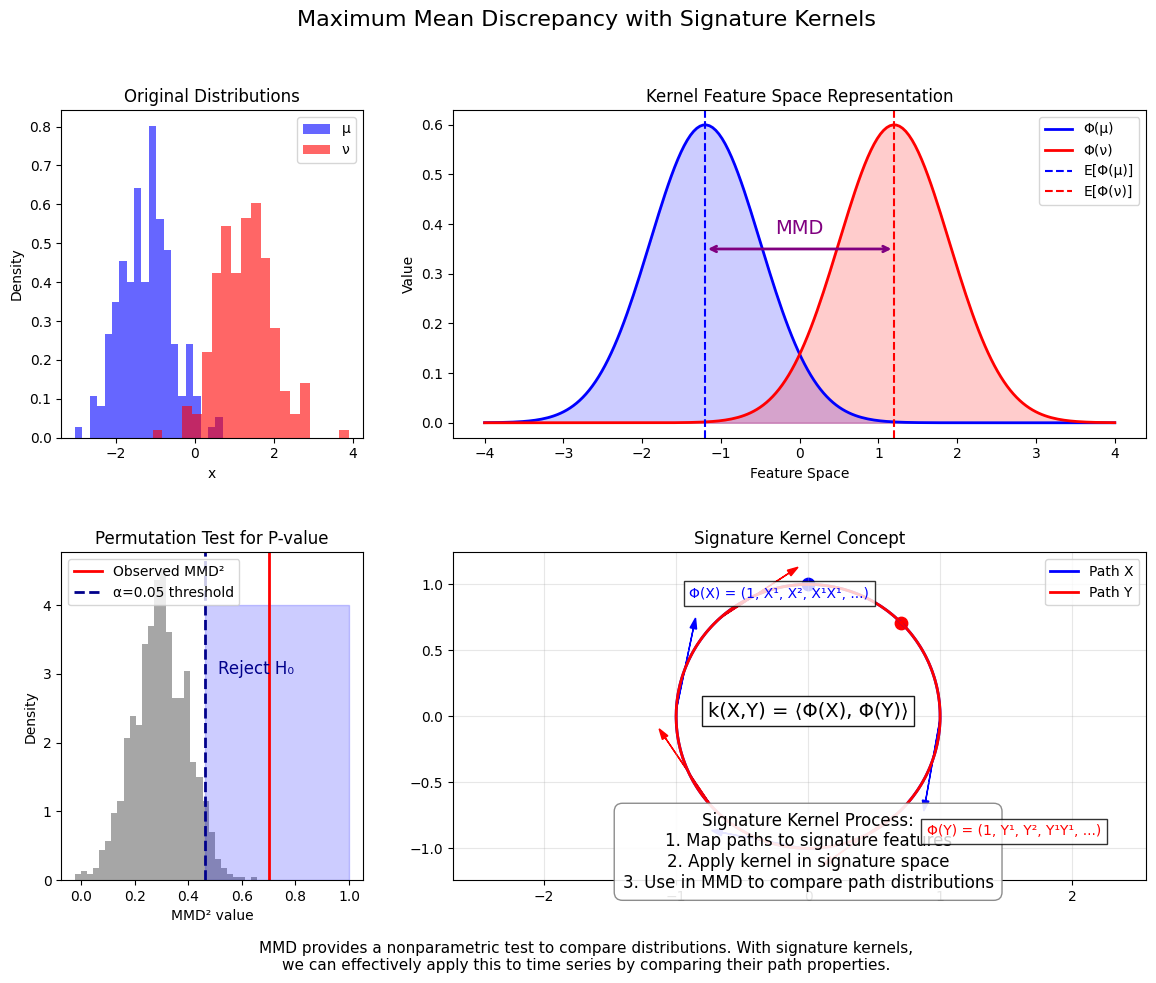

In [60]:
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt

# Create figure with grid layout - increase size for more space
fig = plt.figure(figsize=(14, 10))  # Increased from (12, 8)
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)  # Add spacing between panels

# Panel 1: Two distributions
ax1 = fig.add_subplot(gs[0, 0])
np.random.seed(42)
dist1 = np.random.normal(-1.2, 0.7, 200)
dist2 = np.random.normal(1.2, 0.7, 200)

ax1.hist(dist1, bins=20, alpha=0.6, density=True, color='blue', label='μ')
ax1.hist(dist2, bins=20, alpha=0.6, density=True, color='red', label='ν')
ax1.set_title('Original Distributions')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()

# Panel 2: Feature space representation
ax2 = fig.add_subplot(gs[0, 1:])
x = np.linspace(-4, 4, 200)
y1 = np.exp(-0.5*((x+1.2)/0.7)**2) * 0.6
y2 = np.exp(-0.5*((x-1.2)/0.7)**2) * 0.6

ax2.plot(x, y1, 'b-', linewidth=2, label='Φ(μ)')
ax2.plot(x, y2, 'r-', linewidth=2, label='Φ(ν)')
ax2.fill_between(x, 0, y1, color='blue', alpha=0.2)
ax2.fill_between(x, 0, y2, color='red', alpha=0.2)

# Mean embeddings
ax2.axvline(-1.2, color='blue', linestyle='--', label='E[Φ(μ)]')
ax2.axvline(1.2, color='red', linestyle='--', label='E[Φ(ν)]')

# MMD distance
ax2.annotate('', xy=(1.2, 0.35), xytext=(-1.2, 0.35), 
             arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax2.text(0, 0.38, 'MMD', color='purple', fontsize=14, ha='center')

ax2.set_title('Kernel Feature Space Representation')
ax2.set_xlabel('Feature Space')
ax2.set_ylabel('Value')
ax2.legend(loc='upper right')

# Panel 3: Permutation test
ax3 = fig.add_subplot(gs[1, 0])
np.random.seed(123)
perm_stats = np.random.normal(0.3, 0.1, 1000)
obs_stat = 0.7

ax3.hist(perm_stats, bins=30, alpha=0.7, density=True, color='gray')
ax3.axvline(obs_stat, color='red', linestyle='-', linewidth=2, 
            label='Observed MMD²')

threshold = np.percentile(perm_stats, 95)
ax3.axvline(threshold, color='darkblue', linestyle='--', linewidth=2,
            label='α=0.05 threshold')

ax3.fill_between(np.linspace(threshold, 1.0, 100), 0, 4, alpha=0.2, color='blue')
ax3.text(threshold+0.05, 3, 'Reject H₀', color='darkblue', fontsize=12)

ax3.set_title('Permutation Test for P-value')
ax3.set_xlabel('MMD² value')
ax3.set_ylabel('Density')
ax3.legend(loc='upper left')

# Panel 4: Signature kernel concept
ax4 = fig.add_subplot(gs[1, 1:])

t = np.linspace(0, 1, 100)
path1_x = np.sin(2*np.pi*t)
path1_y = np.cos(2*np.pi*t)
path2_x = np.sin(2*np.pi*t + np.pi/4)
path2_y = np.cos(2*np.pi*t + np.pi/4)

ax4.plot(path1_x, path1_y, 'b-', linewidth=2, label='Path X')
ax4.plot(path2_x, path2_y, 'r-', linewidth=2, label='Path Y')
ax4.scatter(path1_x[0], path1_y[0], color='blue', s=80, marker='o')
ax4.scatter(path2_x[0], path2_y[0], color='red', s=80, marker='o')

# Direction arrows
for i in [25, 50, 75]:
    ax4.arrow(path1_x[i], path1_y[i], 
              (path1_x[i+5]-path1_x[i])*2, (path1_y[i+5]-path1_y[i])*2, 
              head_width=0.05, head_length=0.08, fc='blue', ec='blue')
    ax4.arrow(path2_x[i], path2_y[i], 
              (path2_x[i+5]-path2_x[i])*2, (path2_y[i+5]-path2_y[i])*2, 
              head_width=0.05, head_length=0.08, fc='red', ec='red')

# Adjusted position and improved text box appearance
ax4.text(0, -1.3, 
         "Signature Kernel Process:\n" +
         "1. Map paths to signature features\n" +
         "2. Apply kernel in signature space\n" +
         "3. Use in MMD to compare path distributions",
         ha="center", fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.9, boxstyle='round', 
                  edgecolor='gray', pad=0.5))

# Repositioned text boxes to reduce overlap
ax4.text(-0.9, 0.9, "Φ(X) = (1, X¹, X², X¹X¹, ...)", color='blue', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))
ax4.text(0.9, -0.9, "Φ(Y) = (1, Y¹, Y², Y¹Y¹, ...)", color='red', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))

ax4.text(0, 0, "k(X,Y) = ⟨Φ(X), Φ(Y)⟩", fontsize=14, ha='center',
         bbox=dict(facecolor='white', alpha=0.9))

ax4.set_title('Signature Kernel Concept')
ax4.set_xlim(-2.2, 2.2)  # Expanded plot limits
ax4.set_ylim(-2.2, 2.2)
ax4.axis('equal')
ax4.grid(alpha=0.3)
ax4.legend(loc='upper right')

fig.suptitle('Maximum Mean Discrepancy with Signature Kernels', fontsize=16, y=0.98)
plt.figtext(0.5, 0.02, 
            "MMD provides a nonparametric test to compare distributions. With signature kernels,\n" +
            "we can effectively apply this to time series by comparing their path properties.",
            ha="center", fontsize=11)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.show()